Examining Patient Outcomes: Rudecia Bernard


Libraries and Data Import

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, root_mean_squared_error, log_loss
from sklearn.cluster import k_means
import scipy.stats as stats
import warnings

warnings.filterwarnings("ignore")

hsp = pd.read_csv('/Users/rudeciabernard/Downloads/hospital data analysis.csv')




Exploratory Data Analysis


Goal: Determine which variables are key determinants of patient outcomes, and whether these relationships are statistically significant

In [85]:
#Making hsp easier to work with:


hsp['Gender'] = hsp['Gender'].replace({'Female': 0, 'Male': 1})
hsp['Readmission'] = hsp['Readmission'].replace({'No': 0, 'Yes': 1})
hsp['Outcome'] = hsp['Outcome'].replace({'Stable': 0, 'Recovered': 1})



Correlation Matrix

<Axes: >

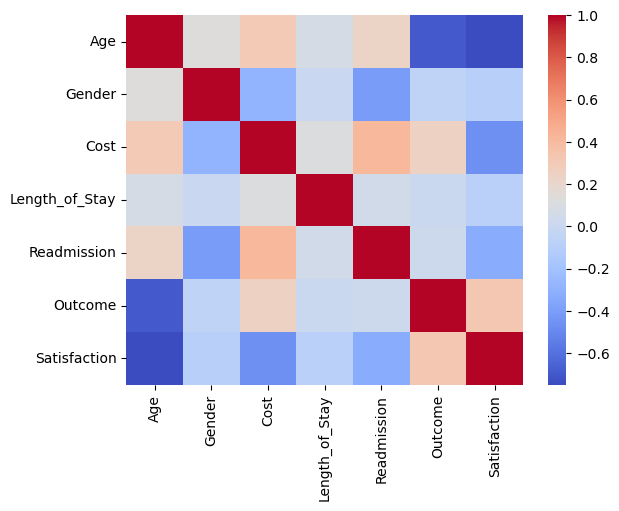

In [86]:
sns.heatmap(hsp.drop('Patient_ID', axis = 1).corr(numeric_only = True), cmap = 'coolwarm')

At a Glance:

1) Age is the strongest predictor of poor outcomes, poor satisfaction, readmission etc. -- not so surprising.

2) Cost and satisfaction seem to be negatively correlated with gender.  Since I encoded the gender with 0 and 1 corresponding to women and men (respectively), men are apparently having a better experience at the hospital.

Given that aging is historically linked with death, I find the second observation a bit more compelling.



Examining Gender-Based Disparities in Patient Outcomes

In [87]:
men_women = hsp.groupby(by = 'Gender').agg({'Satisfaction': ['mean', 'median', 'std'],
                                            'Outcome': ['mean', 'std'],
                                            'Readmission': ['mean', 'std'],
                                            'Cost':['mean', 'median', 'std'] })


men_women.style.highlight_max(axis = 1)




The most striking thing here is the difference in costs, which is almost twice as much on average for women compared to men.
Almost just as shocking is the proportion of women who are readmitted (43% for women versus 7.4% for men!)

Gender-Based Disparities in Cost and Readmission: T-Testing and Visualization

First: a t-test to make sure I'm not going insane:

In [97]:
m = hsp[hsp['Gender'] == 1]
w = hsp[hsp['Gender'] == 0]


cost_t_stat, cost_p_val = stats.ttest_ind(m['Cost'], w['Cost'])
readmit_t_stat, readmit_p_val = stats.ttest_ind(m['Readmission'], w['Readmission'])

print(f'The t statistic and p value for costs by gender are {np.round(cost_t_stat, 3)} and {cost_p_val}, respectively')
print(f'The t statistic and p value for readmission rates by gender are {np.round(readmit_t_stat, 3)} and {readmit_p_val}, respectively')

The t statistic and p value for costs by gender are -9.41 and 3.4028401786586644e-20, respectively
The t statistic and p value for readmission rates by gender are -14.13 and 2.1101264209844014e-41, respectively


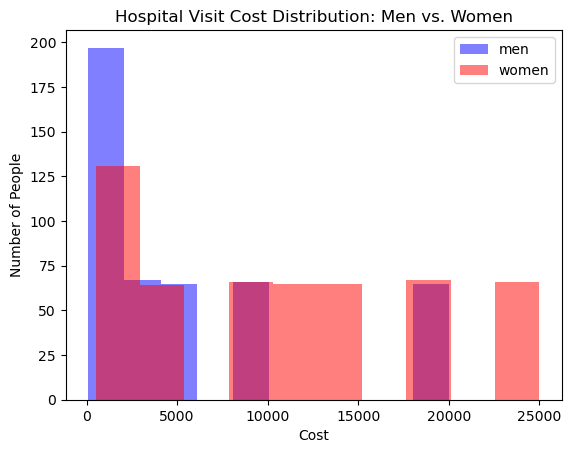

In [89]:


plt.hist(m['Cost'], color = 'b', alpha = 0.5, label = 'men', bins = 10)
plt.hist(w['Cost'], color = 'r', alpha = 0.5, label = 'women', bins = 10)
plt.title('Hospital Visit Cost Distribution: Men vs. Women')
plt.xlabel('Cost')
plt.ylabel('Number of People')
plt.legend()

plt.show()

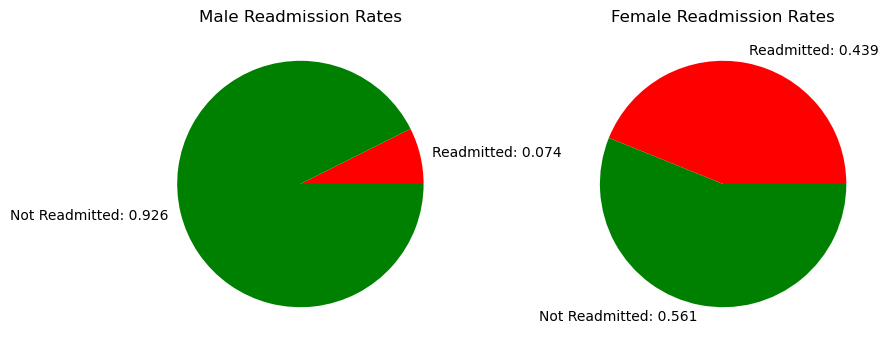

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4)) # 1 row, 2 columns


w_readmit = w['Readmission'].mean()
w_not_readmit = 1 - w['Readmission'].mean()


m_readmit = m['Readmission'].mean()
m_not_readmit = 1 - m['Readmission'].mean()

axs[0].pie(x = (m_readmit, m_not_readmit), colors = ('red', 'green'), labels = [f"Readmitted: {np.round(m_readmit, 3)}",  f'Not Readmitted: {np.round(m_not_readmit, 3)}'])
axs[0].set_title('Male Readmission Rates')

axs[1].pie(x = (w_readmit, w_not_readmit), colors = ('red', 'green'), labels = [f"Readmitted: {np.round(w_readmit, 3)}",  f'Not Readmitted: {np.round(w_not_readmit, 3)}'])
axs[1].set_title('Female Readmission Rates')

plt.tight_layout
plt.show()

Well this is pretty unfortunate, but not unsurprising considering that women's concerns are more likely to be ignored by medical staff. Lingering problems that weren't addressed due to negligence could easily result in readmission further down the road.

Models

Goal: Predict whether the patient will be "stable" (outcome 0) or "recovered" (outcome 1) based given data.

Logistic Regression with Cross-Validation

In [93]:
X = hsp.drop(['Condition', 'Outcome', 'Procedure', 'Patient_ID', 'Satisfaction'], axis = 1).copy()
#Dropping condition and procedure because there are 15 of each, which seemed like quite a few categories for a sample size < 1000.
#Satisfaction was obviously highly correlated with outcome, but this is retrospective information

y = hsp['Outcome'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 42)

log_reg = LogisticRegressionCV(cv = 10)
log_reg.fit(X_train, y_train)
log_preds = log_reg.predict(X_test)


print(f'accuracy of the logistic regression: {accuracy_score(y_test, log_preds)}')
print(f'log loss of the regression: {log_loss(y_test, log_preds)}')

list(X.columns)

pd.DataFrame(log_reg.coef_.reshape(5, 1), columns = ['coefficients'], index = X.columns).sort_values(by = 'coefficients', ascending = False)

accuracy of the logistic regression: 1.0
log loss of the regression: 2.2204460492503136e-16


,coefficients
Readmission,4.825649
Gender,2.813094
Length_of_Stay,0.016118
Cost,0.001108
Age,-1.038058


Decision Tree Classifier

In [95]:
dtc= DecisionTreeClassifier()
dtc.fit(X_train, y_train)

dtc_preds = dtc.predict(X_test)
print(f'decision tree accuracy: {accuracy_score(y_test, dtc_preds)}')
print(f'decision tree log_loss: {log_loss(y_test, dtc_preds)}')



pd.DataFrame(dtc.feature_importances_, index = X.columns, columns = ['feature importance']).sort_values(by = 'feature importance', ascending = False)


decision tree accuracy: 1.0
decision tree log_loss: 2.2204460492503136e-16


,feature importance
Age,0.788922
Cost,0.211078
Gender,0.000000
Length_of_Stay,0.000000
Readmission,0.000000


The tree was able to achieve purity based on age and cost alone-- it likely helps that the data is quite contrived (came from a mysterious kaggle dataset).


Actionable measures at this (very likely AI-generated) hospital:

1) Implicit bias training with an emphasis on gender-based stereotypes (e.g. training module that encourages care providers to be less dismissive of female pain ratings prior to making discharge decisions) *

2) Look further into possible reasons behind disparities in cost. Are they related to the high readmission rates among women, or is there more going on? *



* if you're thinking "hey it may be related to gender-based disease distribution", I thought this as well. When I grouped by disease it actually turned out that each disease was completely split by gender (e.g. 100% of people with diabetes were women, 100% of people with allergic reactions were men, etc.). So  this dataset is pretty wack
